# Loss Masking in SFT

**Or: Why we don't train the model on the question**

Here's a weird thing that happens when you fine-tune a language model: if you're not careful, you end up training it to predict the _instructions_ you give it. Which is...not what we want.

This notebook is about how to avoid that mistake. Short version: loss masking. Let's dig in.

## The Problem: Teaching a Model the Wrong Thing

Picture this. You're training a model on instruction-following. Your data looks like this:

```
[User asks a question] [Model gives a great answer]
```

Or in token-speak:

```
[INSTRUCTION TOKENS] [RESPONSE TOKENS]
```

Now here's the trap. If you compute loss on _all_ the tokens (like you would during pretraining), the model learns two things:

1. How to predict the instruction (bad! the user gives us that)
2. How to predict the response (good! this is what we want)

It's like training a chef by making them memorize both the customer's order _and_ how to cook the dish. We only care about #2!

**Loss masking** is the solution. We set the loss to zero for instruction tokens, so the model only learns from response tokens. The model still _sees_ the instruction (it needs that context), but it doesn't get graded on predicting it.

Think of it like a student taking a test where the questions are provided (not graded) and only the answers count toward their score.

## The Math (Don't Worry, We'll Explain Each Symbol)

Let's write this out formally. But instead of throwing symbols at you, we'll actually explain what each one means.

**Without masking** (the naive approach):

$$\mathcal{L} = -\sum_{t=1}^{T} \log P(x_t | x_{<t})$$

Breaking this down:
- $\mathcal{L}$ is the **loss** — the number we're trying to minimize during training
- $t$ is the **time step** (or position in the sequence) — think of it like an index: token 1, token 2, token 3...
- $T$ is the **total length** of the sequence — if we have 100 tokens, $T = 100$
- $x_t$ is the **token at position** $t$ — this is the actual token we're trying to predict
- $x_{<t}$ means "all tokens _before_ position $t$" — the context the model uses to predict $x_t$
- $P(x_t | x_{<t})$ is the **probability** the model assigns to the correct token, given the context
- $\sum_{t=1}^{T}$ means "sum over all positions from 1 to $T$"

So this formula says: "Calculate the negative log probability for _every_ token in the sequence, then add them all up." The model gets penalized equally for every token it predicts wrong.

**With masking** (the smart approach):

$$\mathcal{L} = -\sum_{t=t_{\text{response}}}^{T} \log P(x_t | x_{<t})$$

Same formula, but notice the sum now starts at $t_{\text{response}}$ instead of $t=1$. 

- $t_{\text{response}}$ is the **position where the response begins** — everything before this is the instruction

Now we only sum over the response tokens! The instruction tokens (positions 1 through $t_{\text{response}}-1$) contribute zero to the loss.

(Yeah, the math is actually pretty simple once you know what the symbols mean.)

In [1]:
import torch
import torch.nn.functional as F

def create_loss_mask(input_ids: torch.Tensor, response_start: int) -> torch.Tensor:
    """
    Create a mask that is 1 for response tokens and 0 for prompt tokens.
    
    Think of this like a highlighting tool: we're marking which tokens
    the model should be graded on (1 = grade this, 0 = ignore this).
    
    Args:
        input_ids: Token IDs, shape (batch_size, seq_len)
        response_start: Token position where response begins
    
    Returns:
        Mask tensor, shape (batch_size, seq_len)
    """
    batch_size, seq_len = input_ids.shape
    mask = torch.zeros(batch_size, seq_len)  # Start with all zeros (ignore everything)
    
    # Set mask to 1 for response tokens (from response_start onwards)
    mask[:, response_start:] = 1.0  # "Grade these tokens!"
    
    return mask

# Let's see this in action
batch_size, seq_len = 2, 10
response_start = 6  # Response begins at position 6

input_ids = torch.randint(0, 1000, (batch_size, seq_len))
mask = create_loss_mask(input_ids, response_start)

print("Input shape:", input_ids.shape)
print("\nLoss mask for first example:")
print(mask[0])
print("\nLet's visualize this more clearly:")
print("Position:", list(range(seq_len)))
print("Mask:    ", mask[0].int().tolist())
print("\n0 = instruction (ignored), 1 = response (graded)")
print(f"\nSo positions 0-5 are the instruction, positions 6-9 are the response.")

Input shape: torch.Size([2, 10])

Loss mask for first example:
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

Let's visualize this more clearly:
Position: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Mask:     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

0 = instruction (ignored), 1 = response (graded)

So positions 0-5 are the instruction, positions 6-9 are the response.


In [2]:
def compute_sft_loss(
    logits: torch.Tensor,
    labels: torch.Tensor,
    loss_mask: torch.Tensor
) -> torch.Tensor:
    """
    Compute SFT loss with masking.
    
    This is where the magic happens. We calculate loss for every token,
    but then multiply by the mask to zero out the instruction tokens.
    
    Args:
        logits: Model outputs, shape (batch_size, seq_len, vocab_size)
                These are the raw predictions before softmax
        labels: Target token IDs, shape (batch_size, seq_len)
                The "correct answers" we want the model to predict
        loss_mask: Mask for loss computation, shape (batch_size, seq_len)
                   1 = include this token, 0 = ignore it
    
    Returns:
        Scalar loss value (a single number to minimize)
    """
    # Shift for next-token prediction
    # At each position, we're predicting the NEXT token
    # So logits[:, :-1] (positions 0 to T-1) predict labels[:, 1:] (positions 1 to T)
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()
    shift_mask = loss_mask[:, 1:].contiguous()
    
    # Flatten everything for cross-entropy
    # PyTorch's cross_entropy expects: (batch*seq_len, vocab_size) and (batch*seq_len,)
    batch_size, seq_len, vocab_size = shift_logits.shape
    flat_logits = shift_logits.view(-1, vocab_size)
    flat_labels = shift_labels.view(-1)
    flat_mask = shift_mask.view(-1)
    
    # Compute per-token loss (one loss value per token)
    per_token_loss = F.cross_entropy(
        flat_logits, 
        flat_labels, 
        reduction='none'  # Don't average yet! We need to mask first
    )
    
    # Apply mask: multiply each loss by its mask value
    # Instruction tokens (mask=0) contribute 0 to the loss
    # Response tokens (mask=1) contribute their full loss
    masked_loss = per_token_loss * flat_mask
    
    # Average over the response tokens only
    # We divide by the sum of the mask (number of response tokens)
    # The +1e-8 prevents division by zero if mask is all zeros (shouldn't happen, but safety!)
    loss = masked_loss.sum() / (flat_mask.sum() + 1e-8)
    
    return loss

# Let's test this with some fake data
batch_size, seq_len, vocab_size = 2, 10, 1000
response_start = 6

# Create fake model outputs and labels
logits = torch.randn(batch_size, seq_len, vocab_size)  # Random predictions
labels = torch.randint(0, vocab_size, (batch_size, seq_len))  # Random targets
loss_mask = create_loss_mask(labels, response_start)

# Compute the loss
loss = compute_sft_loss(logits, labels, loss_mask)

print(f"Masked SFT Loss: {loss.item():.4f}")
print(f"\nThis is the loss computed only over the response tokens (positions {response_start} onwards).")

# For comparison, let's compute loss without masking
no_mask = torch.ones_like(loss_mask)  # All ones = include everything
loss_no_mask = compute_sft_loss(logits, labels, no_mask)

print(f"\nLoss WITHOUT masking: {loss_no_mask.item():.4f}")
print(f"Loss WITH masking:    {loss.item():.4f}")
print(f"\nThey're different! The masked version only counts the response tokens.")

Masked SFT Loss: 7.0888

This is the loss computed only over the response tokens (positions 6 onwards).

Loss WITHOUT masking: 7.3481
Loss WITH masking:    7.0888

They're different! The masked version only counts the response tokens.


## Why This Actually Matters (Beyond the Obvious)

Okay, so we've established that we don't want the model learning to predict instructions. But let's dig deeper into _why_ this matters:

**Without loss masking:**
- **Wasted capacity**: The model dedicates parameters to predicting instruction phrasings instead of response quality. It's like hiring a chef and making them memorize the menu instead of learning to cook.
- **Memorization risk**: The model might start memorizing specific instruction templates. "Oh, the user always asks 'What is...' so I'll just predict that pattern." Not helpful.
- **Diluted gradients**: The gradient signal (the learning signal) gets spread across _all_ tokens. If your instruction is 50 tokens and your response is 50 tokens, half your gradient is wasted.

**With loss masking:**
- **Focused learning**: All the model's capacity goes toward generating good responses. This is what we actually care about.
- **Stronger signal**: The gradient signal is concentrated on the response tokens. It's like turning up the volume on the parts that matter.
- **Better generalization**: The model doesn't overfit to specific instruction phrasings. It learns the general skill of "given a context, generate a good response."

The difference? Real. Measurable. The models trained with proper loss masking just work better.

(This is one of those things that seems like a small implementation detail but actually has a huge impact on final model quality.)

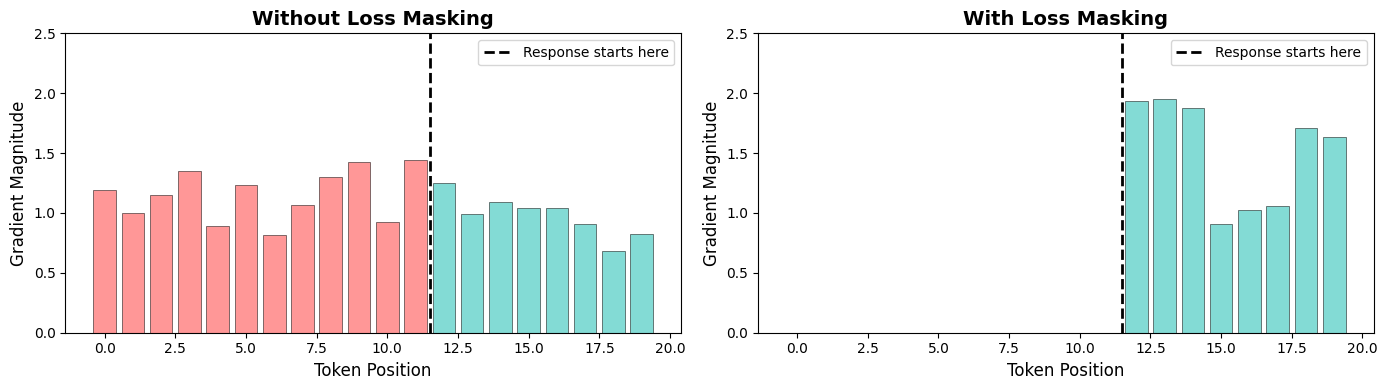

🔴 Red bars = Instruction tokens
🟢 Teal bars = Response tokens

Notice the difference:
- LEFT: Gradients spread across all tokens (wasted on instruction)
- RIGHT: All gradient signal concentrated on response tokens

This is why masking works so well. Same total gradient, focused where it matters.


In [3]:
# Let's visualize what this looks like in practice
import matplotlib.pyplot as plt
import numpy as np

seq_len = 20
response_start = 12

# Simulate gradient magnitudes (these would come from backprop in real training)
# Without masking: all tokens get gradients, roughly similar magnitude
no_mask_grads = np.random.uniform(0.5, 1.5, seq_len)

# With masking: only response tokens get gradients, and they're stronger
# (because the same total gradient is concentrated on fewer tokens)
masked_grads = np.zeros(seq_len)
masked_grads[response_start:] = np.random.uniform(0.8, 2.0, seq_len - response_start)

# Create the visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Color scheme: red for instruction, teal for response
colors = ['#ff6b6b' if i < response_start else '#4ecdc4' for i in range(seq_len)]

# Without masking
axes[0].bar(range(seq_len), no_mask_grads, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_title('Without Loss Masking', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Token Position', fontsize=12)
axes[0].set_ylabel('Gradient Magnitude', fontsize=12)
axes[0].axvline(x=response_start-0.5, color='black', linestyle='--', linewidth=2, label='Response starts here')
axes[0].legend()
axes[0].set_ylim(0, 2.5)

# With masking
axes[1].bar(range(seq_len), masked_grads, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].set_title('With Loss Masking', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Token Position', fontsize=12)
axes[1].set_ylabel('Gradient Magnitude', fontsize=12)
axes[1].axvline(x=response_start-0.5, color='black', linestyle='--', linewidth=2, label='Response starts here')
axes[1].legend()
axes[1].set_ylim(0, 2.5)

plt.tight_layout()
plt.show()

print("🔴 Red bars = Instruction tokens")
print("🟢 Teal bars = Response tokens")
print("\nNotice the difference:")
print("- LEFT: Gradients spread across all tokens (wasted on instruction)")
print("- RIGHT: All gradient signal concentrated on response tokens")
print("\nThis is why masking works so well. Same total gradient, focused where it matters.")

## Real-World Complication: Variable-Length Sequences

Okay, so far we've been pretending that every example has the instruction ending at the same position. But that's not how the real world works.

In a real batch of training data:
- Example 1 might have a 5-token instruction and a 20-token response
- Example 2 might have a 15-token instruction and a 10-token response  
- Example 3 might have a 50-token instruction and a 5-token response

Plus, to make batching work, we pad shorter sequences to the same length. And we definitely don't want to compute loss on padding tokens!

So our masking needs to handle two things:
1. Different response start positions for each example
2. Padding tokens (which should always be ignored)

Let's build that.

In [4]:
def create_loss_mask_batch(
    input_ids: torch.Tensor,
    response_starts: list[int],
    pad_token_id: int
) -> torch.Tensor:
    """
    Create loss mask for a batch with variable response start positions.
    Also masks out padding tokens (because we definitely don't want to learn to predict padding!).
    
    Args:
        input_ids: Token IDs, shape (batch_size, seq_len)
        response_starts: List of response start positions, one per example
        pad_token_id: The token ID used for padding (typically 0)
    
    Returns:
        Mask tensor, shape (batch_size, seq_len)
    """
    batch_size, seq_len = input_ids.shape
    mask = torch.zeros(batch_size, seq_len)
    
    for i, start in enumerate(response_starts):
        # Step 1: Mark response tokens as 1
        mask[i, start:] = 1.0
        
        # Step 2: Mask out any padding tokens (set back to 0)
        # Even if they're in the "response" region
        padding_mask = (input_ids[i] == pad_token_id)
        mask[i] = mask[i] * (~padding_mask).float()
    
    return mask

# Let's create a realistic example with variable-length sequences
batch_size, seq_len = 3, 15
pad_token_id = 0

# Simulate input with different lengths (shorter sequences get padded)
input_ids = torch.randint(1, 1000, (batch_size, seq_len))

# Example 1: ends at position 12, rest is padding
input_ids[0, 12:] = pad_token_id

# Example 2: ends at position 14, just one padding token
input_ids[1, 14:] = pad_token_id

# Example 3: no padding (uses full sequence)
# input_ids[2] stays as-is

# Different response start for each example
response_starts = [5, 7, 6]

# Create the mask
mask = create_loss_mask_batch(input_ids, response_starts, pad_token_id)

print("Let's look at each example in the batch:\n")
for i in range(batch_size):
    print(f"Example {i}:")
    print(f"  Response starts at position: {response_starts[i]}")
    print(f"  Mask: {mask[i].int().tolist()}")
    
    # Count different regions
    instruction_tokens = response_starts[i]
    response_tokens = int(mask[i].sum())
    padding_tokens = (input_ids[i] == pad_token_id).sum().item()
    
    print(f"  → {instruction_tokens} instruction tokens (masked out)")
    print(f"  → {response_tokens} response tokens (counted in loss)")
    print(f"  → {padding_tokens} padding tokens (masked out)")
    print()

print("Notice: Each example can have different regions, and padding is always masked!")

Let's look at each example in the batch:

Example 0:
  Response starts at position: 5
  Mask: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
  → 5 instruction tokens (masked out)
  → 7 response tokens (counted in loss)
  → 3 padding tokens (masked out)

Example 1:
  Response starts at position: 7
  Mask: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
  → 7 instruction tokens (masked out)
  → 7 response tokens (counted in loss)
  → 1 padding tokens (masked out)

Example 2:
  Response starts at position: 6
  Mask: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  → 6 instruction tokens (masked out)
  → 9 response tokens (counted in loss)
  → 0 padding tokens (masked out)

Notice: Each example can have different regions, and padding is always masked!


## The HuggingFace Shortcut

Now, if you're using HuggingFace Transformers (and let's be honest, you probably are), there's a built-in convention that makes this even easier.

Instead of manually creating and applying masks, HuggingFace models use a special token ID: **-100**.

Here's the deal: when you pass labels to a HuggingFace model, any position with label=-100 gets automatically ignored in the loss computation. It's like a pre-built masking system.

So instead of:
```python
labels = [101, 102, 103, 104, ...]  # All the tokens
mask = [0, 0, 0, 1, ...]            # Separate mask tensor
```

You just do:
```python
labels = [-100, -100, -100, 104, ...]  # -100 for instruction, real IDs for response
```

Cleaner, right? Let's see this in action.

In [5]:
def prepare_labels_for_hf(
    input_ids: torch.Tensor,
    response_start: int
) -> torch.Tensor:
    """
    Prepare labels for HuggingFace models using the -100 convention.
    
    This is the standard way to do loss masking in HuggingFace.
    Set instruction tokens to -100 (ignored), keep response tokens as-is.
    
    Args:
        input_ids: Token IDs, shape (batch_size, seq_len)
        response_start: Position where response begins
    
    Returns:
        Labels tensor with -100 for masked positions
    """
    labels = input_ids.clone()  # Start with a copy
    labels[:, :response_start] = -100  # Mask out instruction tokens
    return labels

# Example with a concrete sequence
input_ids = torch.tensor([[101, 102, 103, 104, 105, 201, 202, 203]])
response_start = 5

labels = prepare_labels_for_hf(input_ids, response_start)

print("Original input_ids:", input_ids[0].tolist())
print("Labels for HF:     ", labels[0].tolist())
print("\nWhat this means:")
print("  Positions 0-4: -100 (instruction, ignored in loss)")
print("  Positions 5-7: actual token IDs (response, counted in loss)")

# Let's verify this works with PyTorch's cross_entropy
# (which is what HuggingFace uses under the hood)
vocab_size = 300
fake_logits = torch.randn(1, 8, vocab_size)

# Compute loss - PyTorch's cross_entropy ignores -100 by default!
shift_logits = fake_logits[:, :-1, :].contiguous().view(-1, vocab_size)
shift_labels = labels[:, 1:].contiguous().view(-1)

loss = F.cross_entropy(shift_logits, shift_labels)  # ignore_index=-100 by default!

print(f"\nLoss computed with -100 labels: {loss.item():.4f}")
print("\nPyTorch automatically ignores the -100 tokens. Nice!")
print("(That's why HuggingFace uses -100 — it's PyTorch's default ignore value)")

Original input_ids: [101, 102, 103, 104, 105, 201, 202, 203]
Labels for HF:      [-100, -100, -100, -100, -100, 201, 202, 203]

What this means:
  Positions 0-4: -100 (instruction, ignored in loss)
  Positions 5-7: actual token IDs (response, counted in loss)

Loss computed with -100 labels: 5.8535

PyTorch automatically ignores the -100 tokens. Nice!
(That's why HuggingFace uses -100 — it's PyTorch's default ignore value)


## Wrapping Up

So that's loss masking. Simple idea, big impact.

The key insight: during supervised fine-tuning, we only want the model to learn to generate responses, not to predict the instructions we give it. Loss masking accomplishes this by zeroing out the loss for instruction tokens.

**Two ways to implement it:**
1. Manual masking: create a mask tensor (0 for instruction, 1 for response) and multiply it with your per-token loss
2. HuggingFace convention: set instruction positions to -100 in your labels tensor

Both work. The HuggingFace approach is simpler if you're using their libraries (which you probably are).

**Why it matters:**
- Focuses the model's learning on what actually matters (response quality)
- Prevents wasting capacity on instruction memorization  
- Concentrates gradient signal where it's useful
- Results in better, more generalizable models

Now that we understand loss masking, we're ready to put it all together in a complete SFT training loop. Onward!